In [0]:
import pandas as pd
import json
import numpy as np
import string
import math
import nltk
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#from google.colab import files
#uploaded = files.upload()
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 1.0MB/s 


In [0]:
#Getting the 2% yelp review file (mixed)
link='https://drive.google.com/open?id=1UZrJemORwgEb4mVyVdtkbqOt-VYrgIg7'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_csv_2%.csv')

In [0]:
#Getting the 2% yelp review file (mixed) - with equal rating distribution
link='https://drive.google.com/open?id=1rsJIyZ5tggwFDKYqQ_A3sOSDV6cilXRq'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_eq_2%.csv')

In [0]:
#Getting the 2% food review file
link='https://drive.google.com/open?id=1jZVzy52gDqnPcSmvwfsDJ6GxKOWa6Rgq'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_food_2%.csv')

In [0]:
#Getting the 2% food review file - with equal rating distribution
link='https://drive.google.com/open?id=1VepmxxaKAhx6Yl9C66N2xrVM0g38CzJR'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_foodeq_2%.csv')

In [0]:
#Reading the review file to panda
yelp_2_review_data = pd.read_csv('review_food_2%.csv', sep=",", index_col=0)
yelp_2_review_data = yelp_2_review_data.reset_index(drop=True) #re-indexing
yelp_2_review_data.sample(n=5)    # Randomly select n=5 rows and return them

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# checking the Star rating distribution of dataset

dist = yelp_2_review_data['stars'].value_counts()
dist = dist.sort_index()

# Plotting the Distribution
plt.figure(figsize=(12,8))
ax = sns.barplot(dist.index, dist.values, alpha=0.8)
plt.title("Distribution Chart for Star Rating", fontsize=20)
plt.ylabel("Total Number", fontsize=18)
plt.xlabel("Star Rating Value", fontsize=18)

rects = ax.patches
labels = dist.values
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

In [0]:


#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
yelp_2_review_data['length'] = yelp_2_review_data['text'].apply(len)
yelp_2_review_data.head(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,categories,length
0,i8RhpEgalkeY97p0YQ0JeA,OzGlDEQ_vzH8QU9NBRs-pw,HxLouUPqiou7D6YK5t-DgQ,3,2011-03-06,"Pretty good, but it'll cost ya.\r\n\r\nThe Fre...",1,0,1,wine bars tapas bars canadian new bars night...,765
1,RH_VhBzxegIWT_crf9ButA,lxt4LomsbAjBvk5POhDTEw,giptYxR9l72ogEKaxqch4A,4,2011-05-30,Boyfriend had planned to pick up some sort of ...,8,6,6,food beer wine spirits,708


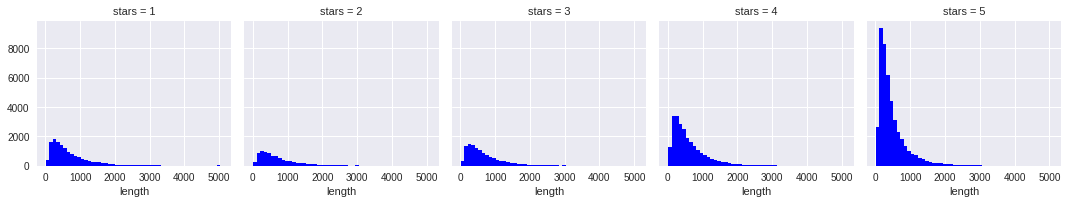

In [0]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=yelp_2_review_data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [0]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = yelp_2_review_data.groupby('stars').mean()
stval

,useful,funny,cool,length
stars,,,,
1,2.288576,0.701579,0.277706,770.819307
2,1.583818,0.666895,0.392674,765.696223
3,1.368968,0.628432,0.688383,717.960764
4,1.371766,0.579066,0.846773,635.976662
5,1.107992,0.356949,0.579169,494.594391


In [0]:
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()

,useful,funny,cool,length
useful,1.000000,0.747709,-0.727590,0.737092
funny,0.747709,1.000000,-0.380144,0.982938
cool,-0.727590,-0.380144,1.000000,-0.488970
length,0.737092,0.982938,-0.488970,1.000000


In [0]:
df=yelp_2_review_data.copy()

# Convert text to lowercase
df.loc[:,'text'] = df['text'].str.lower()

# Remove punctuation
df ['text']= df ['text'].str.replace('[^a-zA-Z]', ' ')

**Stem and remove stop words**

In [0]:
# Create the lemmatizer and the different stemmers
snowball = SnowballStemmer("english")
porter = PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

**Define the 7 different tokenizing function for the TFIDFVectorizer **

In [0]:
# Porter Stemmer tokens ---------------------------------------------
def portertokens(x):
    x = x.split()
    stems = []
    [stems.append(porter.stem(word)) for word in x]
    return stems

In [0]:
# Snowball Stemmer tokens ---------------------------------------------
def snowballtokens(x):
    x = x.split()
    stems = []
    [stems.append(snowball.stem(word)) for word in x]
    return stems

In [0]:
# Lancaster Stemmer tokens ---------------------------------------------
def lancastertokens(x):
    x = x.split()
    stems = []
    [stems.append(lancaster.stem(word)) for word in x]
    return stems

In [0]:
# Lemmetization tokens ---------------------------------------------
def lemmatizertokens(x):
    x = x.split()
    stems = []
    [stems.append(lemmatizer.lemmatize(word,pos="a")) for word in x]
    return stems

In [0]:
# Porter Stemmer & Lemmitization tokens ------------------------------------
def portlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(porter.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

In [0]:
# Snowball Stemmer & Lemmitization tokens ----------------------------------
def snowlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(snowball.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

In [0]:
# Lancaster Stemmer & Lemmitization tokens ----------------------------------
def lanlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(lancaster.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

**Develop features array**

In [0]:
# Define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = portlemtokens, stop_words = 'english', ngram_range=(1,2), max_features=None,  min_df = 0.01)

# Fit the vectorizers to the data
vec=vectorizer.fit(df['text'])

#Converting the words to vectors
feature_words = vec.transform(df['text'])

features = pd.DataFrame(feature_words.toarray(), columns = vectorizer.get_feature_names())
features = pd.concat([features, df[['stars']]], axis = 1)
features.sample(n=5)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

,abl,abov,absolut,accept,accommod,act,actual,ad,add,addit,...,wrap,write,wrong,ye,year,year ago,yelp,young,yummi,stars
15873,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
41391,0.0,0.070792,0.000000,0.0,0.0,0.000000,0.050815,0.0,0.0,0.0,...,0.0,0.000000,0.057779,0.0,0.0,0.0,0.0,0.0,0.0,4
92931,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.102383,0.0,0.0,0.0,...,0.0,0.134462,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
16646,0.0,0.000000,0.071357,0.0,0.0,0.000000,0.061753,0.0,0.0,0.0,...,0.0,0.000000,0.140433,0.0,0.0,0.0,0.0,0.0,0.0,2
23027,0.0,0.000000,0.000000,0.0,0.0,0.205371,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2


In [0]:
# # CLASSIFICATION WITH ALL 5 STAR CLASSES
# x = features.copy()
# y=x.loc[:,'stars']
# print(x.shape)

# from sklearn.model_selection import train_test_split, cross_val_score
# # SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify= x['stars'],random_state=101)

# #Seperating the stars
# y_train=x_train.loc[:,'stars']
# y_test=x_test.loc[:,'stars']

# #Dropping the stars from the x features
# x_train=x_train.drop(columns=['stars'])
# x_test=x_test.drop(columns=['stars'])

In [0]:
# CLASSIFICATION AS KAGGLE EXAMPLE WITH ONLY 3 CLASSES
x = features[(features['stars']==1) | (features['stars']==3) | (features['stars']==5)]
y=x.loc[:,'stars']
print(x.shape)


from sklearn.model_selection import train_test_split, cross_val_score
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify= x['stars'],random_state=101)

#Seperating the stars
y_train=x_train.loc[:,'stars']
y_test=x_test.loc[:,'stars']

#Dropping the stars from the x features
x_train=x_train.drop(columns=['stars'])
x_test=x_test.drop(columns=['stars'])

In [0]:
# # Random Forest
# from sklearn.metrics import classification_report, make_scorer
# from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
# from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict
# from sklearn.ensemble import RandomForestClassifier

# rmfr = RandomForestClassifier(criterion= 'gini', max_depth= None,
#                               min_samples_leaf= 3, min_samples_split=2,
#                               n_estimators= 100,n_jobs=-1, random_state=56)

# #Cross Validation- Accuracy Score
# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
# accuracy=cross_val_score(rmfr,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
# print("Cross Validation Accuracy of Random Forests is: " , round(accuracy,2))

# #Cross Validation- Precision, Recall and F1-Score

# # Variables for average classification report
# originalclass = []
# predictedclass = []

# #Custom Classification Report Scorer
# def classification_report_with_accuracy_score(y_true, y_pred):
#     originalclass.extend(y_true)
#     predictedclass.extend(y_pred)
#     return accuracy_score(y_true, y_pred) # return accuracy score

# multi_score = cross_val_score(rmfr,x_train,y_train,cv=folds, 
#                               scoring=make_scorer(classification_report_with_accuracy_score))

# # Average values in classification report for all folds in a K-fold Cross-validation  
# # print("Classification Report for Random Forest:")
# print(classification_report(originalclass, predictedclass)) 


# #Prediction
# rmfr.fit(x_train,y_train)
# predrmfr = rmfr.predict(x_test)
# print("Confusion Matrix for Random Forest Classifier:")
# print(confusion_matrix(y_test,predrmfr))
# print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,predrmfr))

Cross Validation Accuracy of Random Forests is:  77.27
              precision    recall  f1-score   support

           1       0.80      0.82      0.81     16837
           3       0.72      0.71      0.72     16837
           5       0.80      0.79      0.79     16838

   micro avg       0.77      0.77      0.77     50512
   macro avg       0.77      0.77      0.77     50512
weighted avg       0.77      0.77      0.77     50512

Confusion Matrix for Random Forest Classifier:
[[3423  591  196]
 [ 603 3028  579]
 [ 261  649 3299]]
Score: 77.2
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.81      0.81      4210
           3       0.71      0.72      0.71      4210
           5       0.81      0.78      0.80      4209

   micro avg       0.77      0.77      0.77     12629
   macro avg       0.77      0.77      0.77     12629
weighted avg       0.77      0.77      0.77     12629



In [0]:
# %timeit
# #LinearSVM
# from sklearn import svm
# from sklearn.metrics import classification_report, make_scorer

# model=svm.SVC(random_state=12,kernel='linear',C=6)

# #Cross Validation- Accuracy Score
# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
# accuracy=cross_val_score(model,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
# print("Cross Validation Accuracy for Linear SVM is: " , round(accuracy,2))

# #Cross Validation- Precision, Recall and F1-Score

# # Variables for average classification report
# originalclass = []
# predictedclass = []

# #Custom Classification Report Scorer
# def classification_report_with_accuracy_score(y_true, y_pred):
#     originalclass.extend(y_true)
#     predictedclass.extend(y_pred)
#     return accuracy_score(y_true, y_pred) # return accuracy score

# multi_score = cross_val_score(model,x_train,y_train,cv=folds, 
#                               scoring=make_scorer(classification_report_with_accuracy_score))

# # Average values in classification report for all folds in a K-fold Cross-validation  
# # print("Classification Report for Linear SVM:")
# print(classification_report(originalclass, predictedclass)) 

# #Prediction
# model.fit(x_train,y_train)
# prediction=model.predict(x_test)
# print("Confusion Matrix for Linear SVM:")
# print(confusion_matrix(y_test,prediction))
# print("Score:",round(accuracy_score(y_test,prediction)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,prediction))

In [0]:
# %timeit
# #RBF SVM
# from sklearn import svm
# from sklearn.metrics import classification_report, make_scorer

# model=svm.SVC(random_state=12,kernel='rbf',gamma= 1,C= 30, class_weight='balanced')

# #Cross Validation- Accuracy Score
# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
# accuracy=cross_val_score(model,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
# print("Cross Validation Accuracy of RBF SVM is: " , round(accuracy,2))

# #Cross Validation- Precision, Recall and F1-Score

# # Variables for average classification report
# originalclass = []
# predictedclass = []

# #Custom Classification Report Scorer
# def classification_report_with_accuracy_score(y_true, y_pred):
#     originalclass.extend(y_true)
#     predictedclass.extend(y_pred)
#     return accuracy_score(y_true, y_pred) # return accuracy score

# multi_score = cross_val_score(model,x_train,y_train,cv=folds, 
#                               scoring=make_scorer(classification_report_with_accuracy_score))

# # Average values in classification report for all folds in a K-fold Cross-validation  
# # print("Classification Report for RBF SVM:")
# print(classification_report(originalclass, predictedclass))

# #Prediction
# model.fit(x_train,y_train)
# prediction=model.predict(x_test)
# print("Confusion Matrix for RBF SVM:")
# print(confusion_matrix(y_test,prediction))
# print("Score:",round(accuracy_score(y_test,prediction)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,prediction))

In [0]:
# %timeit
# # K Nearest Neighbour Algorithm
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import classification_report, make_scorer

# knn = KNeighborsClassifier(algorithm='auto',leaf_size=1,
#                            n_jobs=-1,n_neighbors= 15,weights='distance')

# #Cross Validation- Accuracy Score
# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
# accuracy=cross_val_score(knn,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
# print("Cross Validation Accuracy of KNN is: " , round(accuracy,2))

# #Cross Validation- Precision, Recall and F1-Score

# # Variables for average classification report
# originalclass = []
# predictedclass = []

# #Custom Classification Report Scorer
# def classification_report_with_accuracy_score(y_true, y_pred):
#     originalclass.extend(y_true)
#     predictedclass.extend(y_pred)
#     return accuracy_score(y_true, y_pred) # return accuracy score

# multi_score = cross_val_score(knn,x_train,y_train,cv=folds, 
#                               scoring=make_scorer(classification_report_with_accuracy_score))

# # Average values in classification report for all folds in a K-fold Cross-validation  
# # print("Classification Report for KNN:")
# print(classification_report(originalclass, predictedclass))

# #Prediction
# knn.fit(x_train,y_train)
# predknn = knn.predict(x_test)
# print("Confusion Matrix for K Neighbors Classifier:")
# print(confusion_matrix(y_test,predknn))
# print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,predknn))

In [0]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, make_scorer

xgb = XGBClassifier(colsample_bytree=1,gamma=0.5,max_depth= 3,
                    min_child_weight= 3,subsample=1, 
                    n_estimators=100,nthread=1)

#Cross Validation- Accuracy Score
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
accuracy=cross_val_score(xgb,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
print("Cross Validation Accuracy of XGBoost is: " , round(accuracy,2))

#Cross Validation- Precision, Recall and F1-Score

# Variables for average classification report
originalclass = []
predictedclass = []

#Custom Classification Report Scorer
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

multi_score = cross_val_score(xgb,x_train,y_train,cv=folds, 
                              scoring=make_scorer(classification_report_with_accuracy_score))

# Average values in classification report for all folds in a K-fold Cross-validation  
# print("Classification Report for XGBoost:")
print(classification_report(originalclass, predictedclass))

#Prediction
xgb.fit(x_train,y_train)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))


In [0]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, make_scorer
mnb = MultinomialNB()

#Cross Validation- Accuracy Score
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
accuracy=cross_val_score(mnb,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
print("Cross Validation Accuracy for Naive Bayes is: ",round(accuracy,2))

#Cross Validation- Precision, Recall and F1-Score

# Variables for average classification report
originalclass = []
predictedclass = []

#Custom Classification Report Scorer
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

multi_score = cross_val_score(mnb,x_train,y_train,cv=folds, 
                              scoring=make_scorer(classification_report_with_accuracy_score))

# Average values in classification report for all folds in a K-fold Cross-validation  
# print("Classification Report for Naive Bayes:")
print(classification_report(originalclass, predictedclass))

#Prediction
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmnb))

Cross Validation Accuracy for Naive Bayes is:  76.92
              precision    recall  f1-score   support

           1       0.78      0.79      0.79     16837
           3       0.68      0.77      0.72     16837
           5       0.87      0.74      0.80     16838

   micro avg       0.77      0.77      0.77     50512
   macro avg       0.78      0.77      0.77     50512
weighted avg       0.78      0.77      0.77     50512

Confusion Matrix for Multinomial Naive Bayes:
[[3358  750  102]
 [ 617 3221  372]
 [ 322  772 3115]]
Score: 76.76
Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.80      0.79      4210
           3       0.68      0.77      0.72      4210
           5       0.87      0.74      0.80      4209

   micro avg       0.77      0.77      0.77     12629
   macro avg       0.78      0.77      0.77     12629
weighted avg       0.78      0.77      0.77     12629



In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, make_scorer

dt = DecisionTreeClassifier(random_state=10,max_features=None,
                            min_samples_leaf=10, min_samples_split= 2)

#Cross Validation- Accuracy Score
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
accuracy=cross_val_score(dt,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
print("Cross Validation Accuracy for Decision Tree is: ",round(accuracy,2))

#Cross Validation- Precision, Recall and F1-Score

# Variables for average classification report
originalclass = []
predictedclass = []

#Custom Classification Report Scorer
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

multi_score = cross_val_score(dt,x_train,y_train,cv=folds, 
                              scoring=make_scorer(classification_report_with_accuracy_score))

# Average values in classification report for all folds in a K-fold Cross-validation  
# print("Classification Report for Decision Tree:")
print(classification_report(originalclass, predictedclass))

#Prediction
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Score:",round(accuracy_score(y_test,preddt)*100,2))
print("Classification Report:")
print(classification_report(y_test,preddt))

Cross Validation Accuracy for Decision Tree is:  66.2
              precision    recall  f1-score   support

           1       0.70      0.72      0.71     16837
           3       0.59      0.58      0.58     16837
           5       0.70      0.69      0.69     16838

   micro avg       0.66      0.66      0.66     50512
   macro avg       0.66      0.66      0.66     50512
weighted avg       0.66      0.66      0.66     50512

Confusion Matrix for Decision Tree:
[[2995  858  357]
 [ 924 2437  849]
 [ 449  863 2897]]
Score: 65.95
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.71      0.70      4210
           3       0.59      0.58      0.58      4210
           5       0.71      0.69      0.70      4209

   micro avg       0.66      0.66      0.66     12629
   macro avg       0.66      0.66      0.66     12629
weighted avg       0.66      0.66      0.66     12629



In [0]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, make_scorer

mlp = MLPClassifier(activation='relu',hidden_layer_sizes=(200, 200),
                    max_iter=50, random_state=23, solver='lbfgs')

#Cross Validation- Accuracy Score
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
accuracy=cross_val_score(mlp,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
print("Cross Validation Accuracy for MLP is: ",round(accuracy,2))

#Cross Validation- Precision, Recall and F1-Score

# Variables for average classification report
originalclass = []
predictedclass = []

#Custom Classification Report Scorer
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

multi_score = cross_val_score(mlp,x_train,y_train,cv=folds, 
                              scoring=make_scorer(classification_report_with_accuracy_score))

# Average values in classification report for all folds in a K-fold Cross-validation  
# print("Classification Report for MLP:")
print(classification_report(originalclass, predictedclass))


#Prediction
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Cross Validation Accuracy for MLP is:  80.15


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


              precision    recall  f1-score   support

           1       0.85      0.85      0.85     16837
           3       0.76      0.76      0.76     16837
           5       0.84      0.84      0.84     16838

   micro avg       0.82      0.82      0.82     50512
   macro avg       0.82      0.82      0.82     50512
weighted avg       0.82      0.82      0.82     50512



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Confusion Matrix for Multilayer Perceptron Classifier:
[[3562  530  118]
 [ 555 3158  497]
 [ 151  569 3489]]
Score: 80.84
Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.85      0.84      4210
           3       0.74      0.75      0.75      4210
           5       0.85      0.83      0.84      4209

   micro avg       0.81      0.81      0.81     12629
   macro avg       0.81      0.81      0.81     12629
weighted avg       0.81      0.81      0.81     12629



In [0]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer

gbi = GradientBoostingClassifier(random_state=0,learning_rate=0.5,max_depth=3,
                                 max_features=0.5)

#Cross Validation- Accuracy Score
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
accuracy=cross_val_score(gbi,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
print("Cross Validation Accuracy for Gradient: ",round(accuracy,2))

#Cross Validation- Precision, Recall and F1-Score

# Variables for average classification report
originalclass = []
predictedclass = []

#Custom Classification Report Scorer
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

multi_score = cross_val_score(gbi,x_train,y_train,cv=folds, 
                              scoring=make_scorer(classification_report_with_accuracy_score))

# Average values in classification report for all folds in a K-fold Cross-validation  
# print("Classification Report for Gradient:")
print(classification_report(originalclass, predictedclass))

#Prediction
gbi.fit(x_train,y_train)
predgbi = gbi.predict(x_test)
print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test,predgbi))
print("Score:",round(accuracy_score(y_test,predgbi)*100,2))
print("Classification Report:")
print(classification_report(y_test,predgbi))

Cross Validation Accuracy for Gradient:  80.24
              precision    recall  f1-score   support

           1       0.83      0.84      0.83     16837
           3       0.75      0.74      0.75     16837
           5       0.83      0.82      0.83     16838

   micro avg       0.80      0.80      0.80     50512
   macro avg       0.80      0.80      0.80     50512
weighted avg       0.80      0.80      0.80     50512

Confusion Matrix for Gradient Boosting Classifier:
[[3520  536  154]
 [ 544 3152  514]
 [ 198  526 3485]]
Score: 80.43
Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.84      0.83      4210
           3       0.75      0.75      0.75      4210
           5       0.84      0.83      0.83      4209

   micro avg       0.80      0.80      0.80     12629
   macro avg       0.80      0.80      0.80     12629
weighted avg       0.80      0.80      0.80     12629



In [0]:
#Ensemble Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, make_scorer

ens = VotingClassifier(estimators=[('nb',mnb), ('rf',rmfr), ('gb',xgb)], voting='soft')

#Cross Validation- Accuracy Score
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)
accuracy=cross_val_score(ens,x_train,y_train,scoring='accuracy',cv=folds).mean()*100
print("Cross Validation Accuracy for Ensemble is: ",round(accuracy,2))

#Cross Validation- Precision, Recall and F1-Score

# Variables for average classification report
originalclass = []
predictedclass = []

#Custom Classification Report Scorer
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

multi_score = cross_val_score(ens,x_train,y_train,cv=folds, 
                              scoring=make_scorer(classification_report_with_accuracy_score))

# Average values in classification report for all folds in a K-fold Cross-validation  
# print("Classification Report:")
print(classification_report(originalclass, predictedclass))

#Prediction
ens.fit(x_train,y_train)
predens = ens.predict(x_test)
print("Confusion Matrix for Ensemmble:")
print(confusion_matrix(y_test,predens))
print("Score:",round(accuracy_score(y_test,predens)*100,2))
print("Classification Report:")
print(classification_report(y_test,predens))

In [0]:
# Predicting the Rating of a Random Review
i=100000 #Index of the random rating to be predicted
nr = yelp_2_review_data['text'][i]
print(nr)
print("Actual Rating: ",yelp_2_review_data['stars'][i])
# Convert text to lowercase
nr = nr.lower()
# Remove punctuation
nr =nr.replace('[^a-zA-Z]', ' ')
nr_t = vec.transform([nr])
print("Predicted Rating:",mnb.predict(nr_t)[0])

This was my least favorite show I've seen in Vegas so far. It wasn't bad- it's simply just not as good as the other Cirque shows. Nor is it as good as Absynthe or Le Reve. If it is the raunchy stuff you are looking for, see Absynthe. I found every element of Zumanity to just be lacking. It wasn't quite funny enough, wasn't quite sexy enough, wasn't quite acrobatically impressive enough, and the music just wasn't that great. I guess if you have never seen a Cirque show before or have completely sheltered yourself from everyday social issues\/exposure in 2016, you may be left shocked or impressed but I think most people will find this show to be a let down. I was one of them, especially having paid the same amount I paid to see much more impressive shows.
Actual Rating:  3
Predicted Rating: 3
